<a href="https://colab.research.google.com/github/TheodorSergeev/optml_gan/blob/main/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

# Initialisation

In [10]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    # packages to generate requirement.txt
    %pip install nbconvert
    %pip install pipreqs
    # for Frechet inception distance
    %pip install pytorch-fid

    %cd drive/My Drive/optml_gan
    PATH = './'
else:
    PATH = './'

In [11]:
from __future__ import print_function

import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data

import torchvision.utils as vutils
import torchvision.transforms.functional as tff

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d
%matplotlib inline

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Source code

In [13]:
from src.data_handling import *
from src.utils import *
from src.model import *
from src.losses import *
from src.fid import *

loss_dict = {
    "kl": (loss_dis_kl, loss_gen_kl),
    "wass": (loss_dis_wasser, loss_gen_wasser),
    "hinge": (loss_dis_hinge, loss_gen_hinge)
}

# FID

from src.training import *
from src.visualisation import *
from src.serialisation import *

# https://keras.io/examples/generative/conditional_gan/
from src.architectures import *

from src.gridsearch import *
from src.fid_plots import *

# Metrics

In [14]:
# Root directory for dataset
dataroot = PATH + "data/"

# Dataset name
dataset_name = 'mnist' # 'cifar10' or 'mnist'

# Number of workers for dataloader
workers = 0

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 28 # 28 for mnist, 64 for others

# Size of z latent vector (i.e. size of generator input)
nz = 128

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
create_repo_paths(PATH)
dataset, nc = get_dataset(dataset_name, image_size, dataroot)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Load inception model
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
inception_model = InceptionV3([block_idx])
inception_model = inception_model.to(device)

# Init paths
create_repo_paths(PATH)
generated_data_path = PATH + 'generated_data/'
generated_data_path 

# Create a sample of the mnist dataset
batch_size_eval = 32 # 128
num_samples = 1000 # 1000
set_seeds(manualSeed=123)
which = torch.ones(len(dataset)).multinomial(num_samples, replacement=True)
dataset_subset = torch.utils.data.Subset(dataset, which)

real_dataloader = torch.utils.data.DataLoader(dataset_subset, batch_size=batch_size_eval,
                                         shuffle=False, num_workers=workers) # shuffle=False for reproducibility

list_subfolders_with_paths = sorted([f.path for f in os.scandir(generated_data_path) if f.is_dir()])

paths_adam = list_subfolders_with_paths[0:7]
paths_rmsprop = list_subfolders_with_paths[7:14]
paths_sgd = list_subfolders_with_paths[14:]

Random Seed:  123


## Computing FID score

In this section you can either load the FID computations from disk, or run the experiments that will save the files to disk

### Load from disk

In [15]:
all_lr_scores_sgd = pickle_load(generated_data_path + 'all_lr_scores_sgd.pkl')
all_lr_scores_rmsprop = pickle_load(generated_data_path + 'all_lr_scores_rmsprop.pkl')
all_lr_scores_adam = pickle_load(generated_data_path + 'all_lr_scores_adam.pkl')

### Run computation of FID scores

In [ ]:
all_lr_scores_adam = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_adam , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True
                    )
pickle_save(all_lr_scores_adam, generated_data_path + 'all_lr_scores_adam.pkl')
all_lr_scores_adam

In [ ]:
all_lr_scores_rmsprop = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_rmsprop , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True
                    )

pickle_save(all_lr_scores_rmsprop, generated_data_path + 'all_lr_scores_rmsprop.pkl')
all_lr_scores_rmsprop

In [ ]:
all_lr_scores_sgd = get_fid_scores(ngpu, num_samples, real_dataloader, batch_size_eval, device, inception_model, nc, nz, workers,
                    list_paths = paths_sgd , # paths_adam paths_sgd paths_rmsprop
                    which_iterations = [0,50,100,150,200,250,290], #[0,50,100,150,200,250,290] # [0,10,20,30,40,50,60,70,80,90,100,110,120, 130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290]
                    fix_extension = False,
                    calculate_frechet_bool = True,
                    which_lrs = [1e-4,1e-5,1e-6,1e-7], # 1e-1 1e-2 1e-3 loss values are nans quickly
                    )
pickle_save(all_lr_scores_sgd, generated_data_path + 'all_lr_scores_sgd.pkl')
all_lr_scores_sgd

### Plot the FID scores

1e-07 C6
1e-06 C5
1e-05 C4
0.0001 C3
0.001 C2
0.01 C1
0.1 C0


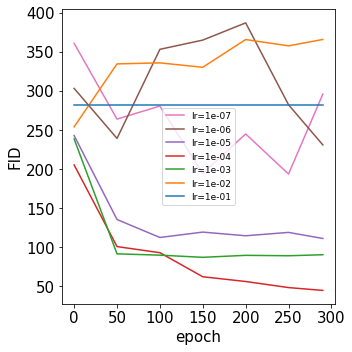

In [44]:
handles, labels = plot_FID(x=[0, 50, 100, 150, 200, 250, 290],
         y=all_lr_scores_adam,
         save_fig=True,
         save_path=PATH + 'img/FID_adam.pdf',
         show_plot=True,
         label_size=9, 
         show_legend=True)


0.0001 C3
1e-05 C4
1e-06 C5
1e-07 C6


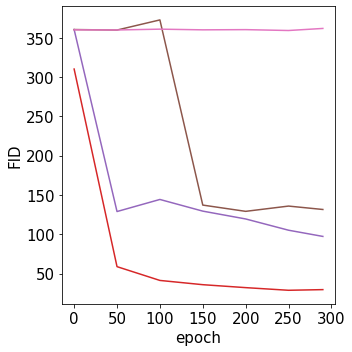

([<matplotlib.lines.Line2D at 0x28a81dab948>,
 ['lr=1e-04', 'lr=1e-05', 'lr=1e-06', 'lr=1e-07'])

In [45]:
plot_FID(x=[0, 50, 100, 150, 200, 250, 290],
         y=all_lr_scores_sgd,
         save_fig=True,
         save_path=PATH + 'img/FID_sgd.pdf',
         show_plot=True,
         label_size=9, 
         show_legend=False)


0.0001 C3
0.001 C2
0.01 C1
0.1 C0
1e-05 C4
1e-06 C5
1e-07 C6


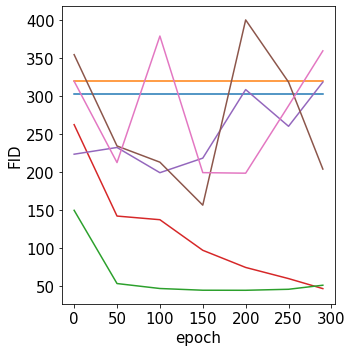

([<matplotlib.lines.Line2D at 0x28a81e61608>,
 ['lr=1e-04',
  'lr=1e-03',
  'lr=1e-02',
  'lr=1e-01',
  'lr=1e-05',
  'lr=1e-06',
  'lr=1e-07'])

In [46]:
plot_FID(x=[0, 50, 100, 150, 200, 250, 290],
         y=all_lr_scores_rmsprop,
         save_fig=True,
         save_path=PATH + 'img/FID_rmsprop.pdf',
         show_plot=True,
         label_size=9, 
         show_legend=False)


## Plotting losses and fake samples from our experiments

In [ ]:
get_loss_plots(generated_data_path,
                paths_sgd, 
                PATH,
                plot_losses=True,
                save_gen_samples=True, 
                show_plot=True, 
                save_fig=True)

In [ ]:
get_loss_plots(generated_data_path, 
                paths_adam, 
                PATH,
                plot_losses=True,
                save_gen_samples=True, 
                show_plot=True, 
                save_fig=True)

In [ ]:
get_loss_plots(generated_data_path, 
                paths_rmsprop, 
                PATH,
                plot_losses=True,
                save_gen_samples=True, 
                show_plot=True, 
                save_fig=True)